In [1]:
import torch
# import torch.optim as optim
import torch.onnx
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import cv2
from shutil import copy2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import pandas as pd
from termcolor import colored 


In [2]:
image_dir = 'cut/depth/images'
label_dir = 'cut/depth/labels'
output_dirs = {
    'train': 'cut/depth/split/train',
    'val': 'cut/depth/split/val',
    'test': 'cut/depth/split/test'
}

for path in output_dirs.values():
    os.makedirs(path, exist_ok=True)

image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

# Sort to make sure images and labels are matched
image_files.sort()
label_files.sort()

assert len(image_files) == len(label_files), "Mismatch between number of images and labels"

In [3]:
# Load Label and create DataFrame
def read_label(label_file):
    with open(os.path.join(label_dir, label_file), 'r') as f:
        label = int(f.read().strip())
    return label

data = []
for img_file, lbl_file in zip(image_files, label_files):
    label = read_label(lbl_file)
    data.append({'image': img_file, 'labels': label})

df = pd.DataFrame(data)

In [4]:
# Print sample of data frame 
print(df.head(4))

                             image  labels
0   gt_2024-09-18_16-41-17_1_1.png       1
1  gt_2024-09-18_16-41-17_1_10.png       1
2  gt_2024-09-18_16-41-17_1_11.png       1
3  gt_2024-09-18_16-41-17_1_12.png       0


In [5]:
# Split data
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 621
Validation samples: 207
Test samples: 207


In [6]:
# Copy files to corresponding directories
def copy_files(df, split):
    for _, row in df.iterrows():
        img_path = os.path.join(image_dir, row['image'])
        dest_path = os.path.join(output_dirs[split], row['image'])
        copy2(img_path, dest_path)

copy_files(train_df, 'train')
copy_files(val_df, 'val')
copy_files(test_df, 'test')

In [7]:
# Verify data preparation
def count_files(dir_path):
    return len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])

print(f"Training images: {count_files(output_dirs['train'])}")
print(f"Validation images: {count_files(output_dirs['val'])}")
print(f"Test images: {count_files(output_dirs['test'])}")

Training images: 621
Validation images: 207
Test images: 207


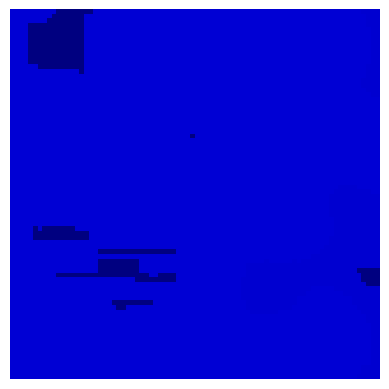

In [17]:
# Show image
random_file = random.choice(os.listdir(output_dirs['train']))
image = cv2.imread(os.path.join("cut", "depth", "split", "train", random_file))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [18]:

class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(image_name).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1:])
        label = torch.tensor(label, dtype=torch.int8)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [19]:

# Define transformations for the training and validation data -> Data augmentation
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
# ])
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

train_dataset = CustomDataset(dataframe=train_df, image_dir=output_dirs['train'], transform=transform)
val_dataset = CustomDataset(dataframe=val_df, image_dir=output_dirs['val'], transform=transform)
test_dataset = CustomDataset(dataframe=test_df, image_dir=output_dirs['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# OLD MODEL/APPROACH
# model = models.efficientnet_b0(pretrained=True)

# model.classifier[1] = nn.Sequential(
#     nn.Linear(model.classifier[1].in_features, 1),
#     nn.Sigmoid()
# )

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Initialize the model's weights using the best practice (Kaiming He initialization for ReLU-based networks)
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [21]:
model = models.resnet50(pretrained=False)

# init weights
model.apply(initialize_weights)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Outputs raw logits (not passed through sigmoid)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/home/aleks/master-lab/cobot_model/.venv/lib64/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleks/master-lab/cobot_model/.venv/lib64/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
# Train Model with Early Stopping for Binary Classification (1 output neuron with Sigmoid)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) 

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()  # Forward pass and remove extra dimensions
            
            loss = criterion(outputs, labels.float())  # Ensure labels are float for BCEWithLogitsLoss
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                
                loss = criterion(outputs, labels.float())
                val_loss += loss.item() * inputs.size(0)
                
                preds = torch.sigmoid(outputs).cpu().numpy()
                val_preds.extend((preds > 0.5).astype(int))  # Convert probabilities to binary predictions
                val_labels.extend(labels.cpu().numpy())
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = np.mean(np.equal(np.array(val_preds), np.array(val_labels)))
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)
                
        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_without_improvement = 0
            
            # Save the best model as .pth
            torch.save(model.state_dict(), 'model/best_model_depth.pth')
            
            # Save the best model as ONNX
            example_input = torch.randn(1, 3, 117, 112).to(device)  # Example input for ONNX export
            torch.onnx.export(model,
                              example_input,                         # Model input
                              'model/best_model_depth.onnx',           # File to save the ONNX model
                              export_params=True,                    # Store the trained weights
                              opset_version=11,                      # ONNX version
                              input_names=['input'],                 # Input name for ONNX
                              output_names=['output'],               # Output name for ONNX
                              dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})  # Allow variable batch size
            
            print(f"Best model saved at epoch {epoch+1}")
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs without improvement')
            break
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Training Loss: {epoch_loss:.4f}, "
              f"Validation Loss: {epoch_val_loss:.4f}, "
              f"Validation Accuracy: {epoch_val_accuracy:.4f}")
    
    return train_losses, val_losses, val_accuracies

train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5)

/tmp/ipykernel_453/3414121902.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  label = int(self.dataframe.iloc[idx, 1:])


Best model saved at epoch 1
Epoch 1/20, Training Loss: 0.1376, Validation Loss: 12.4376, Validation Accuracy: 0.6087
Best model saved at epoch 2
Epoch 2/20, Training Loss: 0.0301, Validation Loss: 0.5113, Validation Accuracy: 0.8841
Best model saved at epoch 3
Epoch 3/20, Training Loss: 0.0220, Validation Loss: 0.0023, Validation Accuracy: 1.0000
Epoch 4/20, Training Loss: 0.0454, Validation Loss: 0.1839, Validation Accuracy: 0.9758
Epoch 5/20, Training Loss: 0.0214, Validation Loss: 0.0715, Validation Accuracy: 0.9855
Epoch 6/20, Training Loss: 0.0214, Validation Loss: 0.0199, Validation Accuracy: 0.9903
Best model saved at epoch 7
Epoch 7/20, Training Loss: 0.0171, Validation Loss: 0.0004, Validation Accuracy: 1.0000
Epoch 8/20, Training Loss: 0.0120, Validation Loss: 0.0053, Validation Accuracy: 1.0000
Epoch 9/20, Training Loss: 0.0126, Validation Loss: 0.0025, Validation Accuracy: 1.0000
Best model saved at epoch 10
Epoch 10/20, Training Loss: 0.0109, Validation Loss: 0.0001, Valid

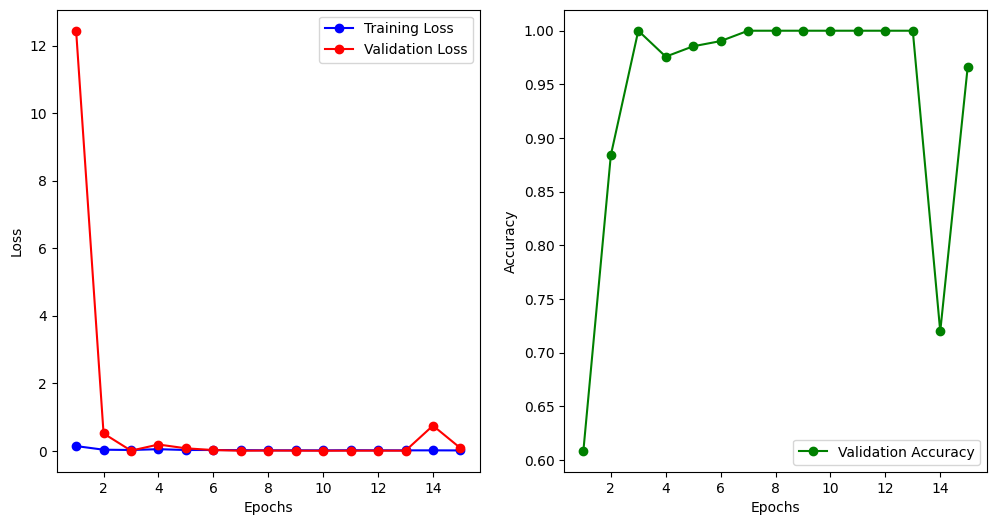

In [23]:
# Plot training history
def plot_training_history(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'go-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

plot_training_history(train_losses, val_losses, val_accuracies)

In [ ]:

def evaluate_model(model, test_loader, criterion, accuracy_threshold=0.8, loss_threshold=0.5):
    model.eval()
    test_loss = 0.0
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs).squeeze(1)  # Ensure the output shape matches the labels
            
            loss = criterion(outputs, labels.float())  # Ensure labels are float for BCEWithLogitsLoss
            test_loss += loss.item() * inputs.size(0)
            
            # Apply sigmoid to convert logits to probabilities for binary classification
            test_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader.dataset)
    
    test_preds_binary = (np.array(test_preds) > 0.5).astype(int)
    
    test_accuracy = np.mean(np.equal(test_preds_binary, np.array(test_labels)))
    
    if test_accuracy >= accuracy_threshold:
        accuracy_display = colored(f'{test_accuracy:.4f}', 'green')
    else:
        accuracy_display = colored(f'{test_accuracy:.4f}', 'red')
    
    if test_loss <= loss_threshold:
        loss_display = colored(f'{test_loss:.4f}', 'green')
    else:
        loss_display = colored(f'{test_loss:.4f}', 'red')
    
    print(f'Test Loss: {loss_display}, Accuracy: {accuracy_display}')

evaluate_model(model, test_loader, criterion)
